###Build Pytorch neural network using high level primitives

In [19]:
import numpy as np
from typing import Callable
import torch
import torch.nn as nn

####3d-2d nonlinear data generation

In [20]:
# n = 200
# d = 3
# x = np.random.uniform(-1, 1, (n, d))

# weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
# bias_true = np.array([0.5, 0.1])

# y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true

# # Convert numpy to tensors
# x_tensor = torch.tensor(x, requires_grad=True).float()
# y_true_tensor = torch.tensor(y_true, requires_grad=True).float()

# print(f'x: {x_tensor.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true_tensor.shape}')
n_samples = 200
input_dim = 3

x_true = torch.FloatTensor(n_samples, input_dim).uniform_(-1,1)
weights_true = torch.FloatTensor([[5, 1, 4],[2, 1, 2]]).T
bias_true = torch.tensor([0.5, 0.25])
# y = (x ** 2) @ weights_true + x @ weights_true + bias_true
y_true = torch.mm(x_true ** 2, weights_true) + torch.mm(x_true, weights_true) + bias_true

x_tensor = x_true.clone().detach().requires_grad_(True).float()
y_true_tensor = y_true.clone().detach().requires_grad_(True).float()

print(f'x: {x_tensor.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true_tensor.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2]), y: torch.Size([200, 2])


#### Compose 3 layers neural network using linear and relu


In [21]:
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden, ouput_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, ouput_dim)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    r2 = self.relu1(r1)
    l2 = self.linear2(r2)
    return l2

####Initialize loss model and convert data to tensors

Define loss function. <br />
Compose nonlinear model with 3d input and 2d output, 10 neurons in hidden layer. <br />

In [22]:
loss = nn.MSELoss()

# 10 neurons for hidden layers
model = TorchModel(3, 10, 2)

y_pred_tensor = model(x_tensor)

loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(21.7791, grad_fn=<MseLossBackward>)


In [23]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(21.7791, grad_fn=<MseLossBackward>)
tensor(16.9161, grad_fn=<MseLossBackward>)


####Train three dimention data

In [24]:
def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    if epoch % 500 == 0:
      print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.05, num_epochs=10000)
y_pred = model(x_tensor)
y_pred = y_pred.cpu().detach().numpy()

tensor(16.9161, grad_fn=<MseLossBackward>)
tensor(0.1439, grad_fn=<MseLossBackward>)
tensor(0.0903, grad_fn=<MseLossBackward>)
tensor(0.0739, grad_fn=<MseLossBackward>)
tensor(0.0654, grad_fn=<MseLossBackward>)
tensor(0.0551, grad_fn=<MseLossBackward>)
tensor(0.0476, grad_fn=<MseLossBackward>)
tensor(0.0414, grad_fn=<MseLossBackward>)
tensor(0.0373, grad_fn=<MseLossBackward>)
tensor(0.0333, grad_fn=<MseLossBackward>)
tensor(0.0306, grad_fn=<MseLossBackward>)
tensor(0.0283, grad_fn=<MseLossBackward>)
tensor(0.0257, grad_fn=<MseLossBackward>)
tensor(0.0239, grad_fn=<MseLossBackward>)
tensor(0.0218, grad_fn=<MseLossBackward>)
tensor(0.0203, grad_fn=<MseLossBackward>)
tensor(0.0191, grad_fn=<MseLossBackward>)
tensor(0.0183, grad_fn=<MseLossBackward>)
tensor(0.0178, grad_fn=<MseLossBackward>)
tensor(0.0176, grad_fn=<MseLossBackward>)


####Plot the output and the real data using tsne

Plot functions

In [25]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 1], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

In [26]:
y_pred_np = y_pred
y_true_np = y_true.detach().numpy()
x_np = x_true.detach().numpy()

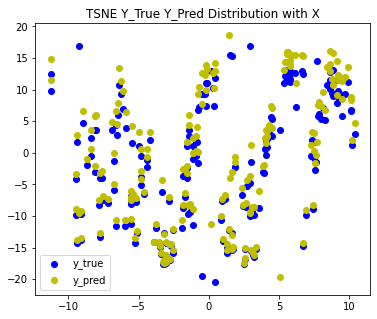

In [27]:
plot_distribution(x_np, y_true_np, y_pred_np)

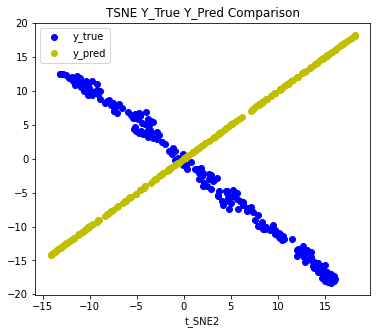

In [28]:
plot_comparison(y_true_np, y_pred_np)

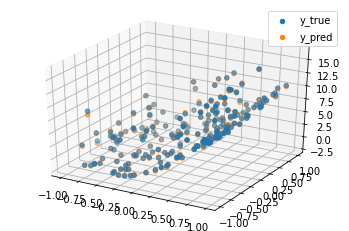

In [29]:
plot_3d(x_np, y_true_np[:, 0], y_pred=y_pred_np[:, 0])